#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 
____

**Описание данных:** Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).
____

**Задача:** Построить модель для такого предсказания. Для этого нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.
____

**Цель:** Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.
____

<h2>Содержание<span class="tocSkip"></span></h2>
<br>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

## Подготовка

In [1]:
#Подгружаем необходимые библиотеки для работы с данными и машинного обучения
import warnings
import timeit

import pandas as pd

import catboost
import phik
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  Lasso,
                                  ElasticNet)
from catboost import CatBoostRegressor
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             f1_score, 
                             roc_curve, 
                             roc_auc_score, 
                             confusion_matrix,
                             accuracy_score,
                             make_scorer)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose

#Подгружаем дополнительные полезные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Уберем warnings, чтобы не мешали
warnings.filterwarnings("ignore")

In [3]:
#Загружаем файлы с данными
try:
    data = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Спринт 12. Временные ряды/taxi.csv', 
                       index_col=[0], 
                       parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv',
                      index_col=[0], 
                       parse_dates=[0])

In [4]:
#Проверяем датафрейм
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


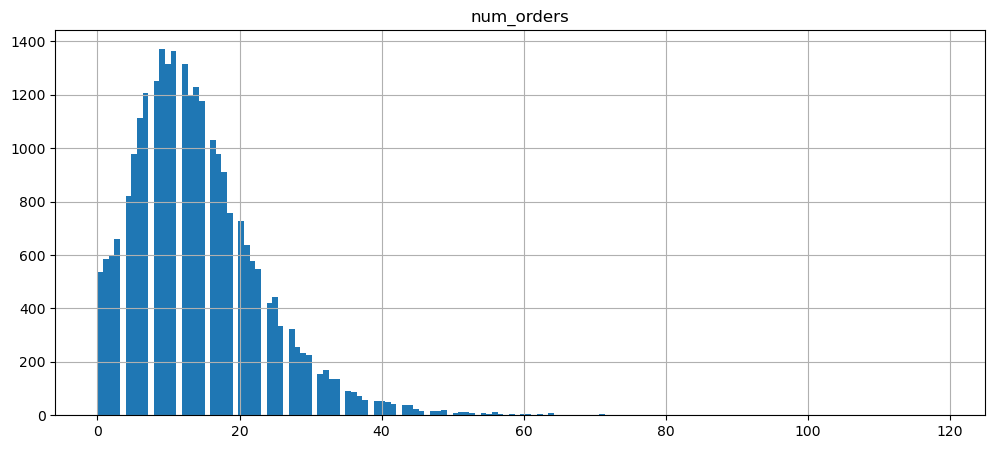

In [5]:
#Выведем информацию о датафрейме
data.info()
data.hist(figsize=(12,5), bins=150);

Отлично, пропущенные значения отсутствуют.

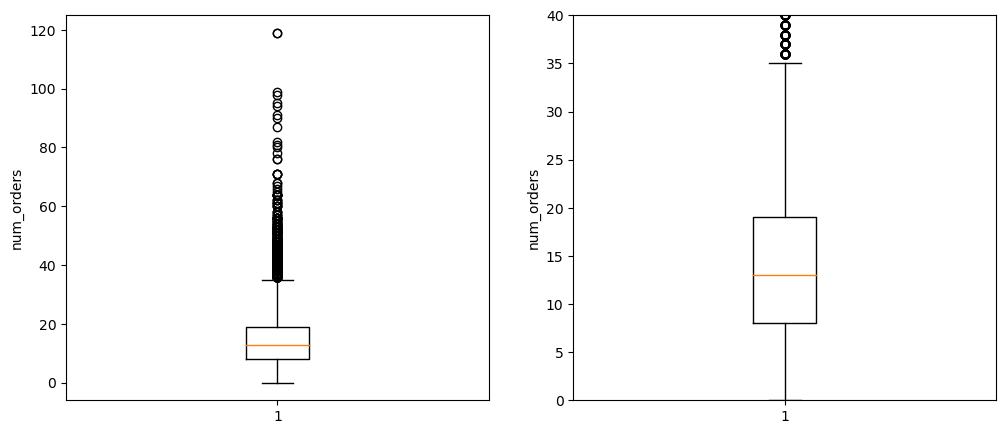

In [6]:
#Выведем описание датафрейма
data.describe().transpose().round(3)

#Посмотрим на диаграмму с усами для Power
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize=(12,5))

plt.subplot(121)
plt.boxplot(data['num_orders']);
plt.ylabel('num_orders');

plt.subplot(122)
plt.boxplot(data['num_orders']);
plt.ylim([0, 40]);
plt.ylabel('num_orders');

Данные без особых вылетов. 

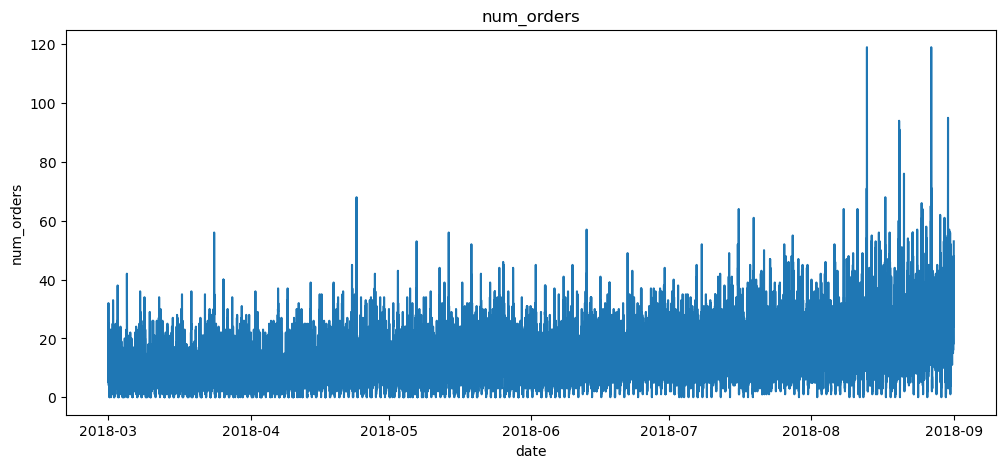

In [7]:
#Выполним сортирову данных
data.sort_index(inplace=True)

#Построим график для временного ряда
plt.figure(figsize=(12,5))
plt.plot(data)
plt.title('num_orders')
plt.xlabel('date');
plt.ylabel('num_orders');

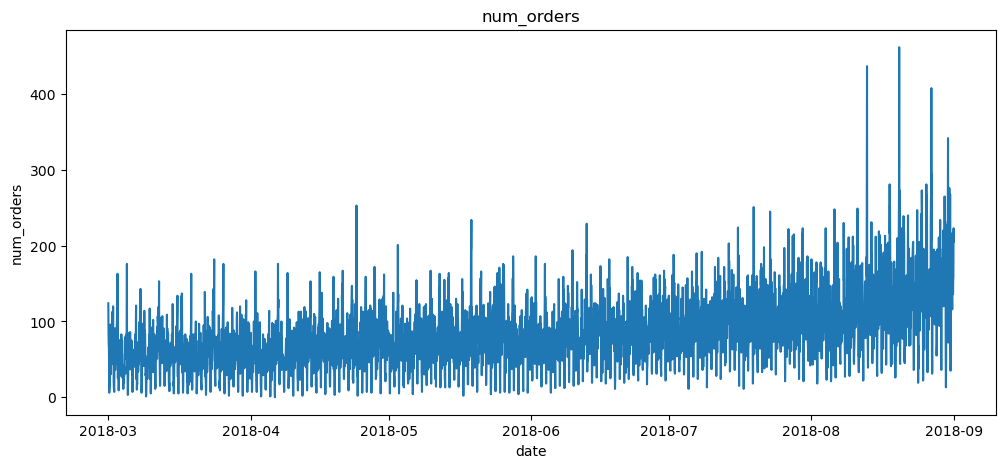

In [8]:
#Выполним ресемплирование по 1 часу
data_resample = data.resample('1H').sum()

#Построим график для временного ряда
plt.figure(figsize=(12,5))
plt.plot(data_resample)
plt.title('num_orders')
plt.xlabel('date');
plt.ylabel('num_orders');

**Выводы:**

* Значения в датафрейме проверены. Пропущенных нет, особых вылетов также;
* Проведено ресемплирвоание по 1 часу.

## Анализ

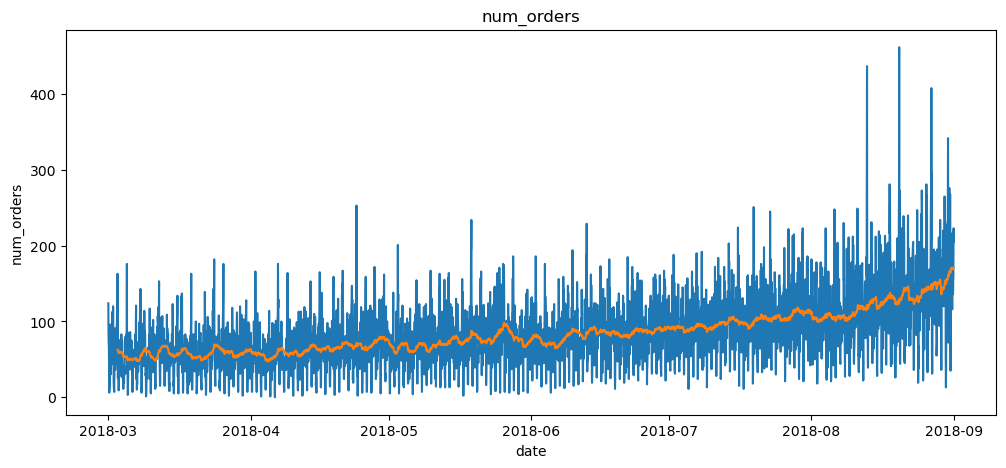

In [9]:
#Построим скользящее среднее для данного временного рядя
data_resample['rolling_mean'] = data_resample['num_orders'].rolling(50).mean()

#Построим график для временного ряда
plt.figure(figsize=(12,5))
plt.plot(data_resample)
plt.title('num_orders')
plt.xlabel('date');
plt.ylabel('num_orders');

По скользящему среднему можно увидеть, что начиная с весны происходит рост заказов на такси для маршрутов, связанных с аэропортом. Это логично, ведь наступает период отпусков, поэтому люди массово перемещаются между городами и странами. 

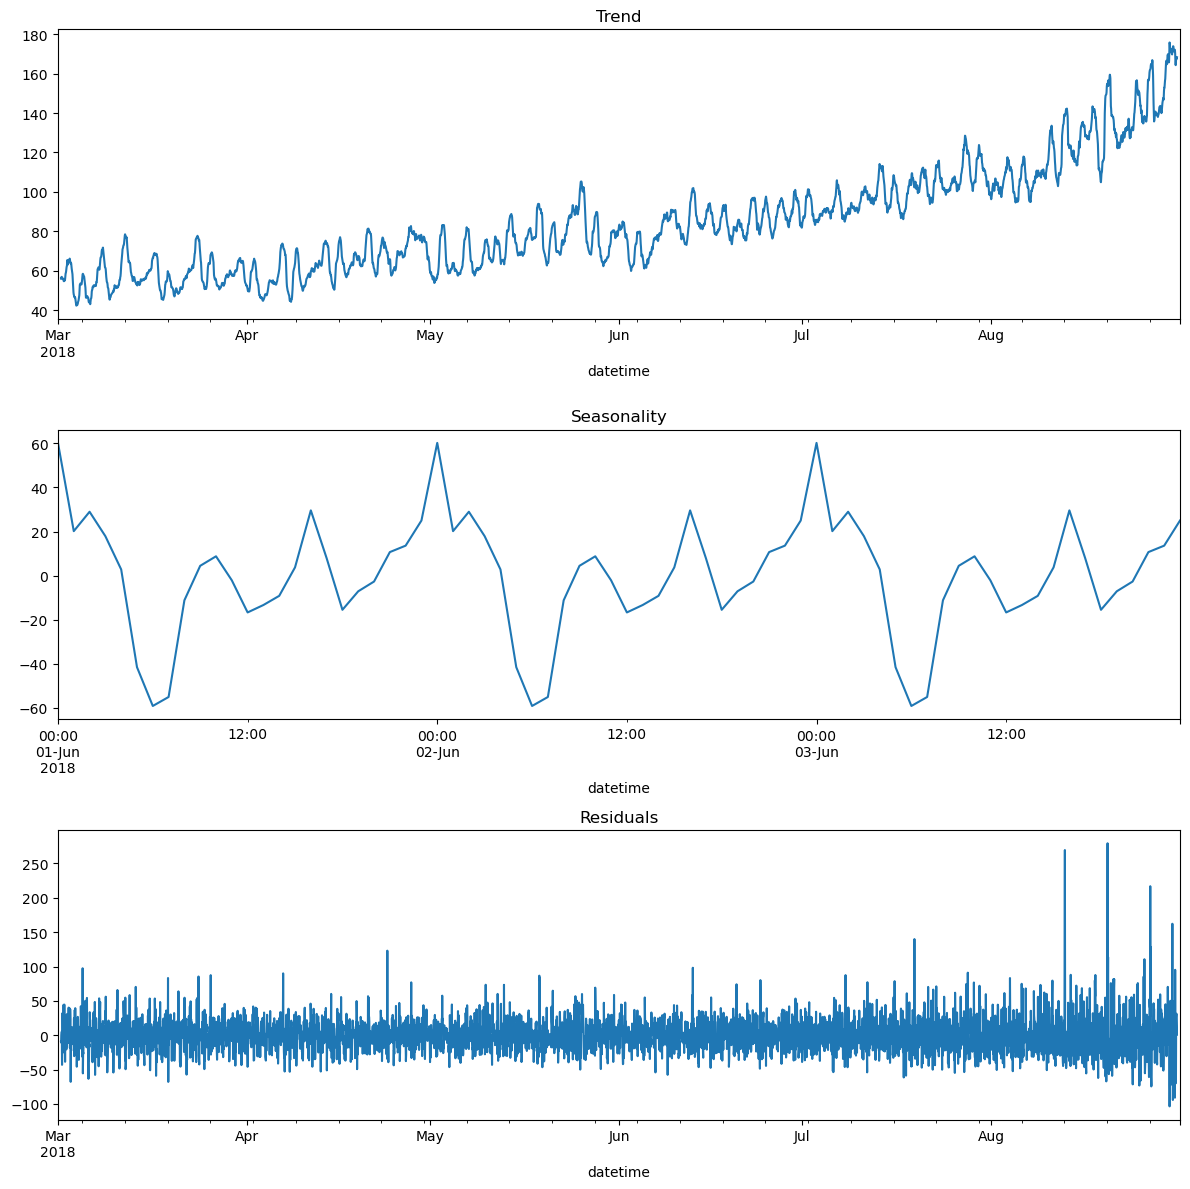

In [10]:
#Проверим на тренды и сезонность данный временной ряд
decomposed = seasonal_decompose(data_resample['num_orders'])
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

#Сезонность проверим для интервала в 3 дня
plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-06-03'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Выводы:**

* По тренду и скользящему среднему мы наблюдаем рост заказов, начиная с начала весны, что вероятно связано с массовыми перелетами людей из-за отпусков;
* Согласно графику сезонности, с 12 часов ночи происходит снижение активности людей. Это связано с тем, что большинство людей не любят ночные рейсы из-за утомительности. Но примерно с 6 утра и до 12 ночи люди с нарастающей активностью вызывают такси с маршрутом, связанным с аэропортом.  

## Обучение

Сначала необходимо создать признаки, по которым будет происходить прогноз и обучение модели. Это:
* Год, месяц, день, день недели, час;
* Несколько признаков со смещенным целевым признаком на разное количество шагов, чтобы понять, будет ли уменьшаться или увеличиваться временной ряд;
* Скользящее среднее для задания тренда.

In [11]:
#Сначала напишем функцию для создания признаков
def make_features(data_1, max_lag, rolling_mean_size):
    data_for_model = data_1.copy()
    data_for_model['year'] = data_for_model.index.year
    data_for_model['month'] = data_for_model.index.month
    data_for_model['day'] = data_for_model.index.day
    data_for_model['dayofweek'] = data_for_model.index.dayofweek
    data_for_model['hour'] = data_for_model.index.hour
    
    for i in range(1, max_lag + 1):
        data_for_model[f'lag_{i}'] = data_for_model['num_orders'].shift(i)

    data_for_model['rolling_mean'] = data_for_model['lag_1'].rolling(rolling_mean_size).mean()
    return data_for_model

In [12]:
#Напишем функцию для разбивки на выборки train и test
def train_test(data_1):
    data_2 = data_1.dropna()
    features = data_2.drop('num_orders', axis=1)
    target = data_2['num_orders']
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, shuffle=False, test_size=0.1)
    return features_train, features_test, target_train, target_test

Используем для сравнения 5 моделей: LightGBM, Catboost, RandomForestRegressor, LinearRegression, DecisionTreeRegressor

In [13]:
best_score_set = []

In [14]:
best_score_LR = 1000000
#Применим функции для создания признаков и разбиения на выборки
for max_lag in range(1, 5):
    for rolling_mean_size in range(10, 60, 10):
        features_train, features_test, target_train, target_test = train_test(make_features(data_resample, 
                                                                                            max_lag, 
                                                                                            rolling_mean_size))
        
        #Используем LightGBM вместе с RandomizedSearchCV
        LR = LinearRegression()
        
        rs_space={}
        
        tscv = TimeSeriesSplit(n_splits=5)
        
        LR_random = RandomizedSearchCV(LR, rs_space, n_iter=1, scoring='neg_mean_absolute_error', cv=tscv)
        model_random = LR_random.fit(features_train, target_train)
        
        score = (-1) * round(model_random.best_score_, 3)
        
        if score < best_score_LR:  
            best_score_LR = score
            best_model_LR = model_random.best_estimator_
            best_params_LR = model_random.best_params_
            max_lag_LR = max_lag
            rolling_mean_size_LR = rolling_mean_size
    
best_score_set.append(best_score_LR)
    
print(20 * '-')
print('Для LR:')
print('Лучшая модель:', best_model_LR)
print('Лучшие гиперпараметры:', best_params_LR)
print('Лучший MAE:', best_score_LR)
print(f'Лучший лаг и окно: {max_lag_LR} и {rolling_mean_size_LR}')

--------------------
Для LR:
Лучшая модель: LinearRegression()
Лучшие гиперпараметры: {}
Лучший MAE: 24.171
Лучший лаг и окно: 1 и 20


In [15]:
best_score_DT = 1000000
#Применим функции для создания признаков и разбиения на выборки
for max_lag in range(1, 5):
    for rolling_mean_size in range(10, 60, 10):
        features_train, features_test, target_train, target_test = train_test(make_features(data_resample, 
                                                                                            max_lag, 
                                                                                            rolling_mean_size))
        
        #Используем LightGBM вместе с RandomizedSearchCV
        DT = DecisionTreeRegressor(random_state=12345)
        
        rs_space={'max_depth':[None] + [i for i in range(2, 7)]}
        
        tscv = TimeSeriesSplit(n_splits=5)
        
        DT_random = RandomizedSearchCV(DT, rs_space, n_iter=100, scoring='neg_mean_absolute_error', cv=tscv)
        model_random = DT_random.fit(features_train, target_train)
        
        score = (-1) * round(model_random.best_score_, 3)
        
        if score < best_score_DT:  
            best_score_DT = score
            best_model_DT = model_random.best_estimator_
            best_params_DT = model_random.best_params_
            max_lag_DT = max_lag
            rolling_mean_size_DT = rolling_mean_size
    
best_score_set.append(best_score_DT)
    
print(20 * '-')
print('Для DT:')
print('Лучшая модель:', best_model_DT)
print('Лучшие гиперпараметры:', best_params_DT)
print('Лучший MAE:', best_score_DT)
print(f'Лучший лаг и окно: {max_lag_DT} и {rolling_mean_size_DT}')

--------------------
Для DT:
Лучшая модель: DecisionTreeRegressor(max_depth=6, random_state=12345)
Лучшие гиперпараметры: {'max_depth': 6}
Лучший MAE: 21.191
Лучший лаг и окно: 4 и 40


`Для LGBM, catboost и RandomForestRegressor при использовании перебора лага и окна Jupyter вылетает, поэтому используем такое же окно и максимальный лаг, как и для DT (считаю локально, скорее всего, не хватает моего ноутовского i5).`

In [16]:
best_score_LGBM = 1000000
#Применим функции для создания признаков и разбиения на выборки
for max_lag in range(4, 5):
    for rolling_mean_size in range(40, 50, 10):
        features_train, features_test, target_train, target_test = train_test(make_features(data_resample, 
                                                                                            max_lag, 
                                                                                            rolling_mean_size))
        
        #Используем LightGBM вместе с RandomizedSearchCV
        LGBM = lgb.LGBMRegressor(verbose=-1, n_jobs=-1, random_state=12345)
        
        rs_space={'max_depth':([None] + [i for i in range(2, 7)]),
                  'n_estimators':np.arange(10, 500, 50),
                 }
        
        tscv = TimeSeriesSplit(n_splits=5)
        
        LGBM_random = RandomizedSearchCV(LGBM, rs_space, n_iter=100, scoring='neg_mean_absolute_error', cv=tscv)
        model_random = LGBM_random.fit(features_train, target_train)
        
        score = (-1) * round(model_random.best_score_, 3)
        
        if score < best_score_LGBM:  
            best_score_LGBM = score
            best_model_LGBM = model_random.best_estimator_
            best_params_LGBM = model_random.best_params_
            max_lag_LGBM = max_lag
            rolling_mean_size_LGBM = rolling_mean_size
    
best_score_set.append(best_score_LGBM)
    
print(20 * '-')
print('Для LGBM:')
print('Лучшая модель:', best_model_LGBM)
print('Лучшие гиперпараметры:', best_params_LGBM)
print('Лучший MAE:', best_score_LGBM)
print(f'Лучший лаг и окно: {max_lag_LGBM} и {rolling_mean_size_LGBM}')

--------------------
Для LGBM:
Лучшая модель: LGBMRegressor(max_depth=None, n_estimators=60, random_state=12345, verbose=-1)
Лучшие гиперпараметры: {'n_estimators': 60, 'max_depth': None}
Лучший MAE: 19.059
Лучший лаг и окно: 4 и 40


In [17]:
best_score_cat = 1000000
#Применим функции для создания признаков и разбиения на выборки
for max_lag in range(4, 5):
    for rolling_mean_size in range(40, 50, 10):
        features_train, features_test, target_train, target_test = train_test(make_features(data_resample, 
                                                                                            max_lag, 
                                                                                            rolling_mean_size))
        
        #Используем LightGBM вместе с RandomizedSearchCV
        catboost = CatBoostRegressor(verbose=0, random_state=12345)
        
        rs_space={'max_depth':[None] + [i for i in range(2, 7)],
                  'iterations':np.arange(10, 500, 50),
                 }
        
        tscv = TimeSeriesSplit(n_splits=5)
        
        catboost_random = RandomizedSearchCV(catboost, rs_space, n_iter=50, scoring='neg_mean_absolute_error', cv=tscv)
        model_random = catboost_random.fit(features_train, target_train)
        
        score = (-1) * round(model_random.best_score_, 3)
        
        if score < best_score_cat:  
            best_score_cat = score
            best_model_cat = model_random.best_estimator_
            best_params_cat = model_random.best_params_
            max_lag_cat = max_lag
            rolling_mean_size_cat = rolling_mean_size
    
best_score_set.append(best_score_cat)
    
print(20 * '-')
print('Для catboost:')
print('Лучшая модель:', best_model_cat)
print('Лучшие гиперпараметры:', best_params_cat)
print('Лучший MAE:', best_score_cat)
print(f'Лучший лаг и окно: {max_lag_cat} и {rolling_mean_size_cat}')

--------------------
Для catboost:
Лучшая модель: <catboost.core.CatBoostRegressor object at 0x0000029A5DE461F0>
Лучшие гиперпараметры: {'max_depth': 4, 'iterations': 360}
Лучший MAE: 19.48
Лучший лаг и окно: 4 и 40


In [18]:
best_score_RF = 1000000
#Применим функции для создания признаков и разбиения на выборки
for max_lag in range(4, 5):
    for rolling_mean_size in range(40, 50, 10):
        features_train, features_test, target_train, target_test = train_test(make_features(data_resample, 
                                                                                            max_lag, 
                                                                                            rolling_mean_size))
        
        #Используем RandomForestRegressor вместе с RandomizedSearchCV
        RF = RandomForestRegressor(verbose=0, n_jobs=-1, random_state=12345)
        
        rs_space={'max_depth':[None] + [i for i in range(2, 7)],
                  'n_estimators':np.arange(1, 100, 2),
                 }
        
        tscv = TimeSeriesSplit(n_splits=5)
        
        RF_random = RandomizedSearchCV(RF, rs_space, n_iter=100, scoring='neg_mean_absolute_error', cv=tscv)
        model_random = RF_random.fit(features_train, target_train)
        
        score = (-1) * round(model_random.best_score_, 3)
        
        if score < best_score_RF:  
            best_score_RF = score
            best_model_RF = model_random.best_estimator_
            best_params_RF = model_random.best_params_
            max_lag_RF = max_lag
            rolling_mean_size_RF = rolling_mean_size
    
best_score_set.append(best_score_RF)
    
print(20 * '-')
print('Для RF:')
print('Лучшая модель:', best_model_RF)
print('Лучшие гиперпараметры:', best_params_RF)
print('Лучший MAE:', best_score_RF)
print(f'Лучший лаг и окно: {max_lag_RF} и {rolling_mean_size_RF}')

--------------------
Для RF:
Лучшая модель: RandomForestRegressor(n_estimators=99, n_jobs=-1, random_state=12345)
Лучшие гиперпараметры: {'n_estimators': 99, 'max_depth': None}
Лучший MAE: 18.751
Лучший лаг и окно: 4 и 40


In [19]:
#Сделаем сводную таблицу
pivot_model = pd.DataFrame({'RMSE' : best_score_set}, 
                            index=['Линейная регрессия', 'Дерево решений', 'LGBM', 'Catboost', 'Случайный лес'])

pivot_model

,RMSE
Линейная регрессия,24.171
Дерево решений,21.191
LGBM,19.059
Catboost,19.480
Случайный лес,18.751


**Выводы:**

* Выполнено обучение и определены лучшие гиперпараметры для 5-ти моделей: LightGBM, Catboost, LinearRegression, DecisionTreeRegressor, RandomForestTree
* Лучшая модель с RMSE значительно <48: LGBMRegressor(max_depth=None, n_estimators=60, random_state=12345, verbose=10)

## Тестирование

--------------------
RMSE тестовой выборки: 44.608


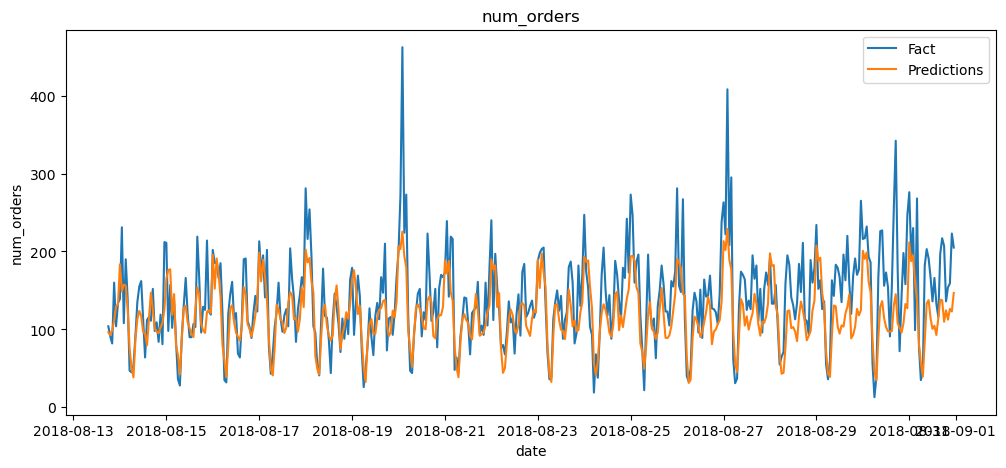

In [20]:
#Найдем RMSE на тестовой выборке
features_train, features_test, target_train, target_test = train_test(make_features(data_resample, 
                                                                                    max_lag_LGBM, 
                                                                                    rolling_mean_size_LGBM))
model = best_model_LGBM
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse_test = mean_squared_error(target_test, predictions) ** 0.5
print('-' * 20)
print('RMSE тестовой выборки:', round(rmse_test, 3))

#Построим график для временного ряда
prediction = pd.DataFrame({'RMSE' : predictions}, index=target_test.index)
plt.figure(figsize=(12,5))
plt.plot(target_test, label='Fact')
plt.plot(prediction, label='Predictions')
plt.title('num_orders')
plt.xlabel('date');
plt.ylabel('num_orders');
plt.legend();

In [21]:
#Сравним результаты тестовой модели с константной
dummy_clf = DummyRegressor()
dummy_clf.fit(features_train, target_train)
predict_dummy = dummy_clf.predict(features_test)
rmse_dummy = mean_squared_error(target_test, predict_dummy) ** 0.5
print('Итоговый RMSE константной модели составляет:', rmse_dummy.round(3))

Итоговый RMSE константной модели составляет: 84.645


**Выводы:**

* На тестовой выборке получилось, что RMSE <48 и RMSE константной модели.

## Общие выводы

**1. Подготовка данных**:

* Значения в датафрейме проверены. Пропущенных нет, особых вылетов также;
* Проведено ресемплирвоание по 1 часу.

------

**2. Анализ**:

* По тренду и скользящему среднему мы наблюдаем рост заказов, начиная с начала весны, что вероятно связано с массовыми перелетами людей из-за отпусков;
* Согласно графику сезонности, с 12 часов ночи происходит снижение активности людей. Это связано с тем, что большинство людей не любят ночные рейсы из-за утомительности. Но примерно с 6 утра и до 12 ночи люди с нарастающей активностью вызывают такси с маршрутом, связанным с аэропортом.  

------

**3. Обучение**:

* Выполнено обучение и определены лучшие гиперпараметры для 5-ти моделей: LightGBM, Catboost, LinearRegression, DecisionTreeRegressor, RandomForestRegressor
* Лучшая модель с RMSE значительно <48: LGBMRegressor(max_depth=None, n_estimators=60, random_state=12345, verbose=10)

------

**4. Тестирование**:

* На тестовой выборке получилось, что RMSE <48 и RMSE константной модели.